In [1]:
import os
import numpy as np
import pandas as pd
import tsfresh
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline

Прочитаємо окремі набори даних та подивимось що там всередині

In [2]:
iddle_list = []
running_list = []
stairs_list = []
walking_list = []
columns_presentation = {"accelerometer_X" :"r", "accelerometer_Y" : "g", "accelerometer_Z": "b"}

def read_dir(path, data_list):
    with os.scandir(path) as file_it:
        for entry in file_it:
            if entry.is_file():
                data_list.append(pd.read_csv(entry.path))

read_dir("data/idle/", iddle_list)
read_dir("data/running/", running_list)
read_dir("data/stairs/", stairs_list)
read_dir("data/walking/", walking_list)


In [3]:
def create_plots(data_list, columns_dict, limit = 0):
    counter = 0
    for df in data_list:
        plt.figure(figsize=(15, 5))

        for key, color in columns_dict.items():
            plt.plot(df[key], color=color)

        plt.grid()
        plt.show()

        if (limit > 0) and (counter == limit):
            break

        counter += 1

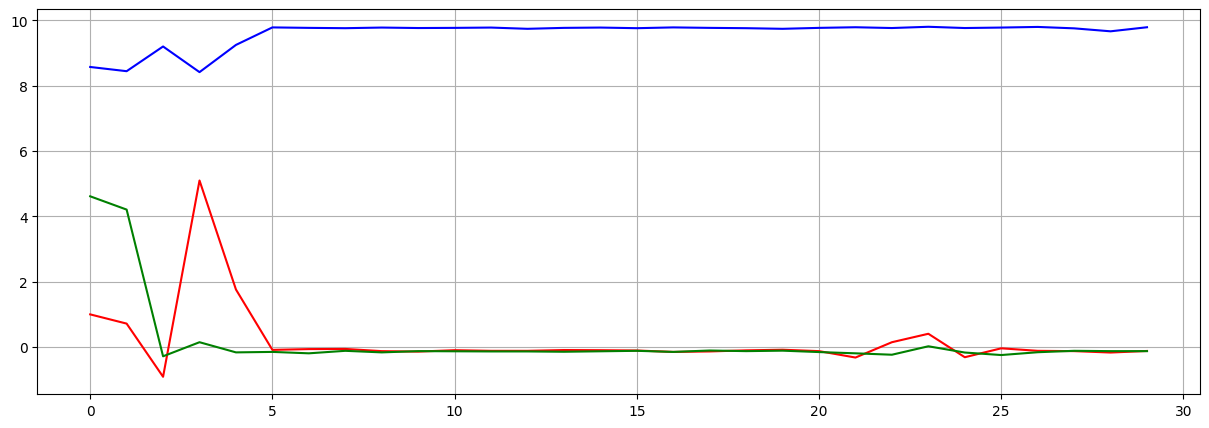

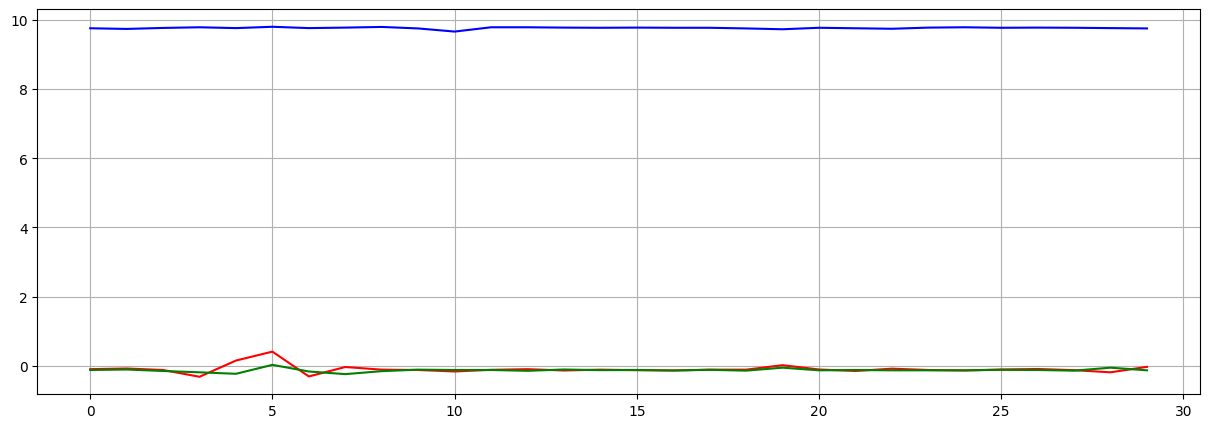

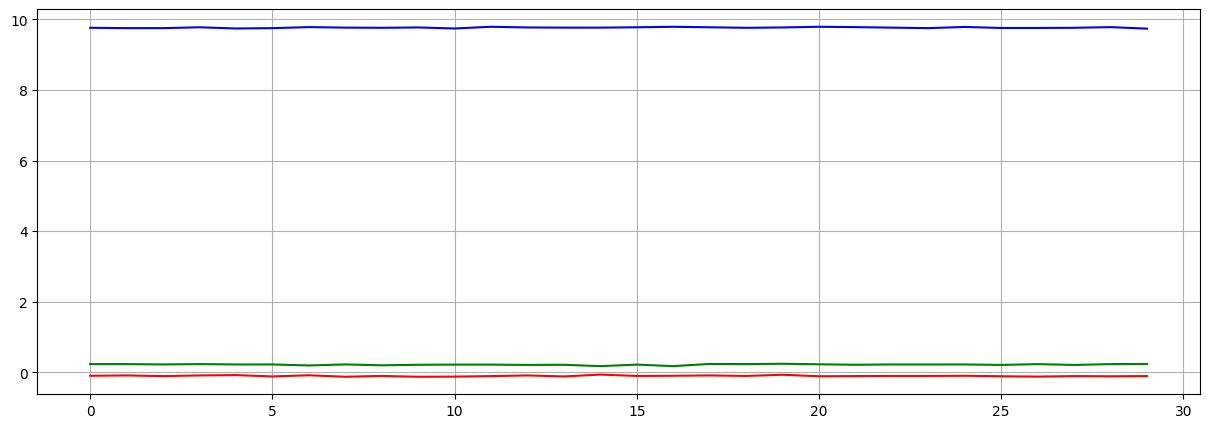

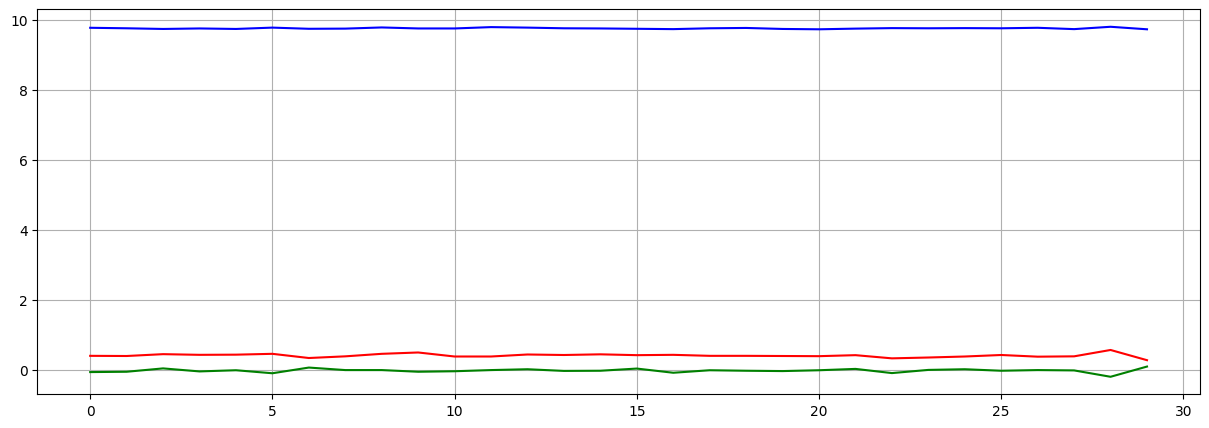

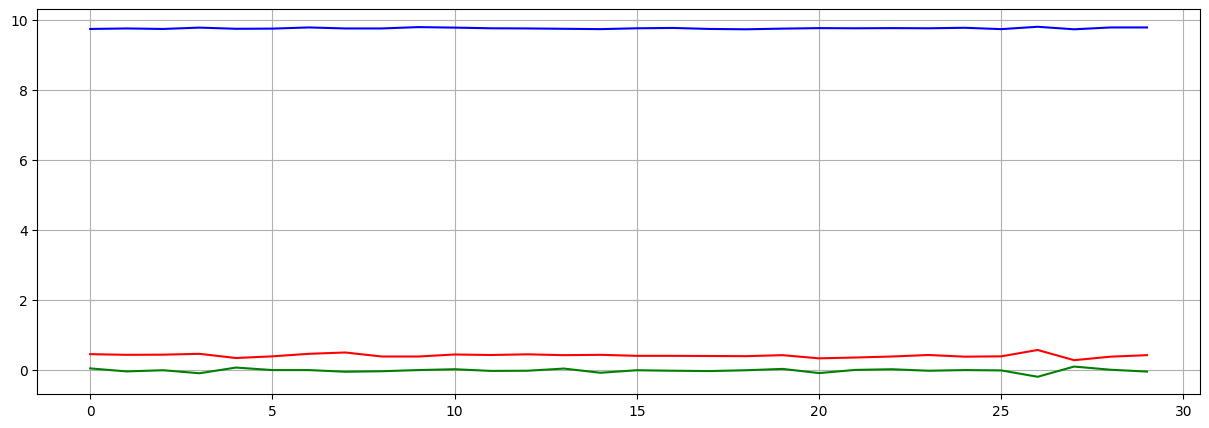

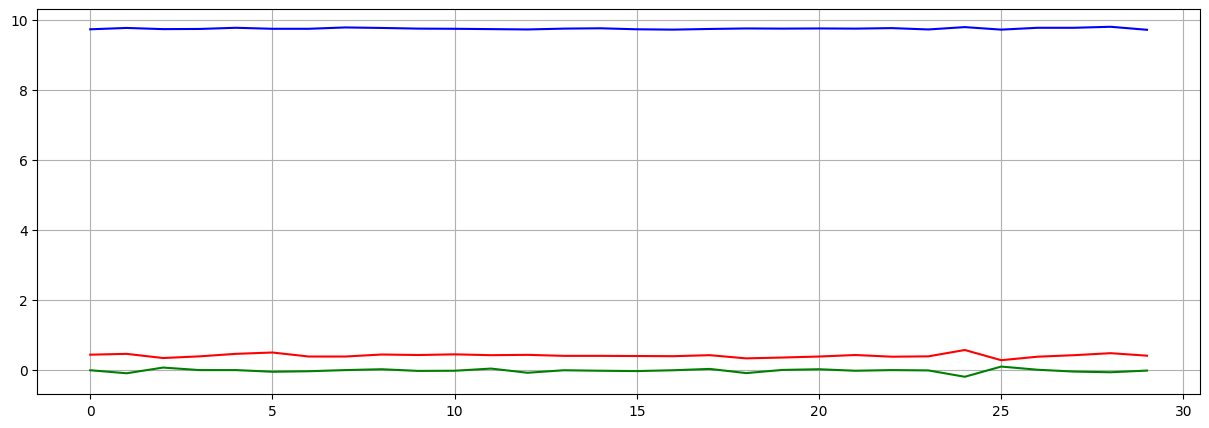

In [4]:
create_plots(iddle_list, columns_presentation, 5)


Наразі виведено 5 графіків.

Якщо ж вивести графіки по всім даним, можна зробити висновки:
1. Для більшості наборів даних характерні незначні коливання біля якоїсь середньої точки
2. Вісі можуть бути переплутані в різних виборках
3. В більшості випадків по двум вісям дані коливаються в діапазоні 0-1, третя вісь близько 10
4. Є поодинокі випадки, коли амплітуда коливань дещо вища і середня суттєво відрізняється
5. Є поодинокі випадки (і вони йдуть один за одним), які схожі на рух хвилі


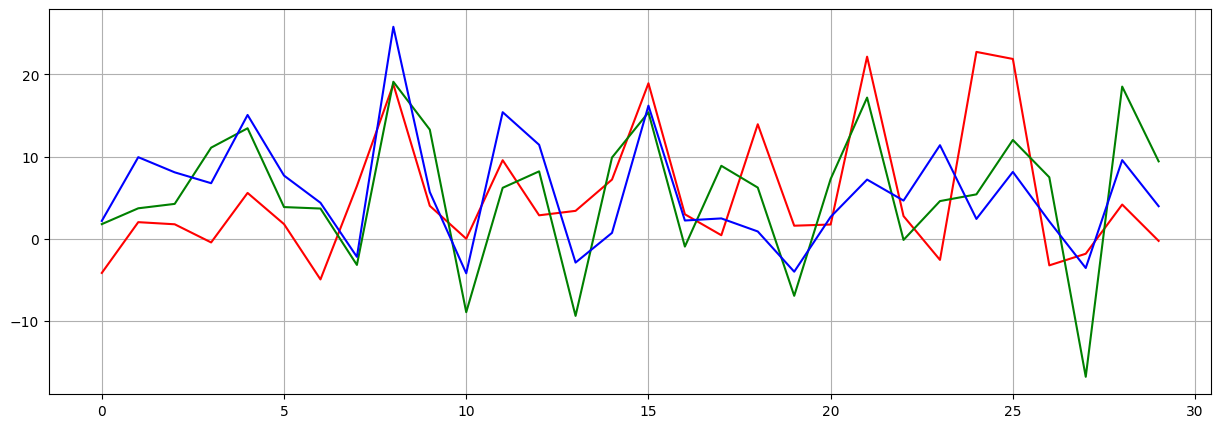

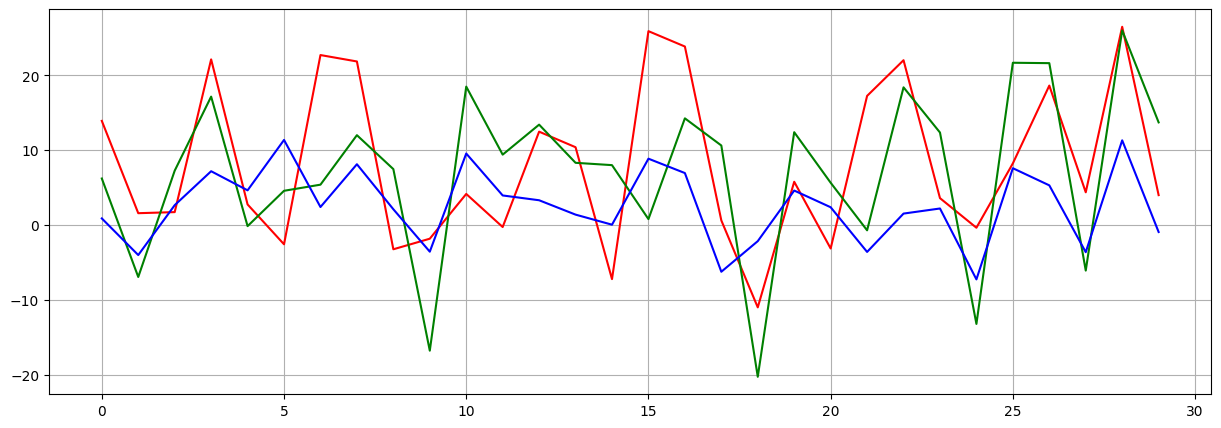

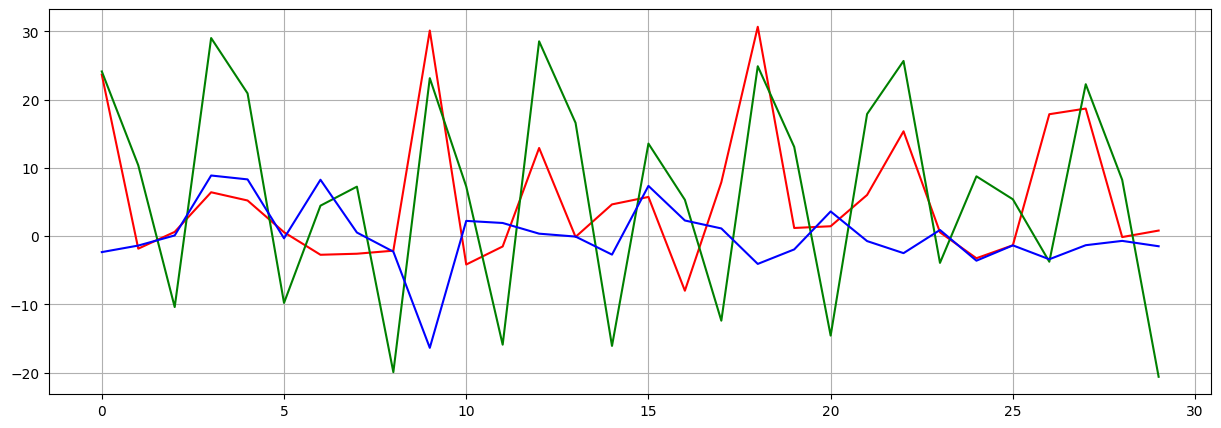

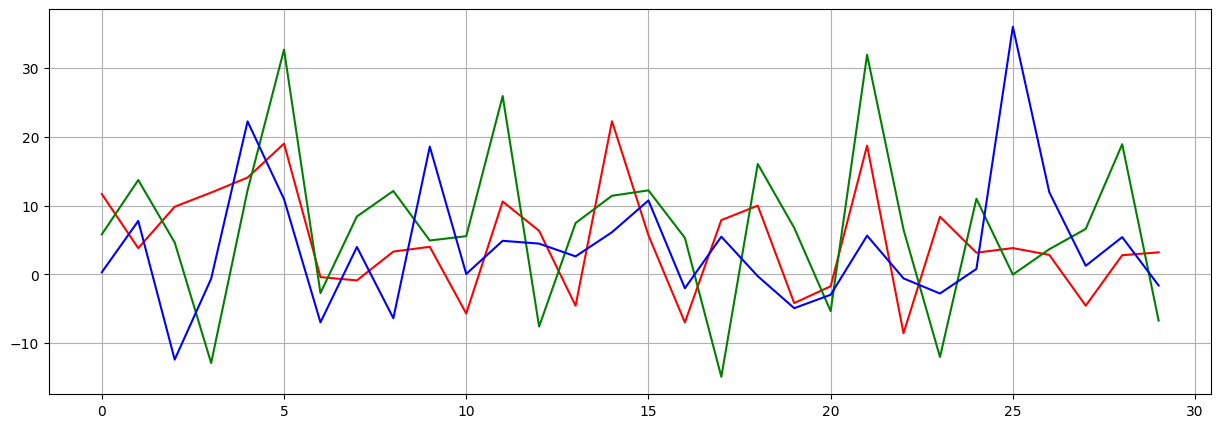

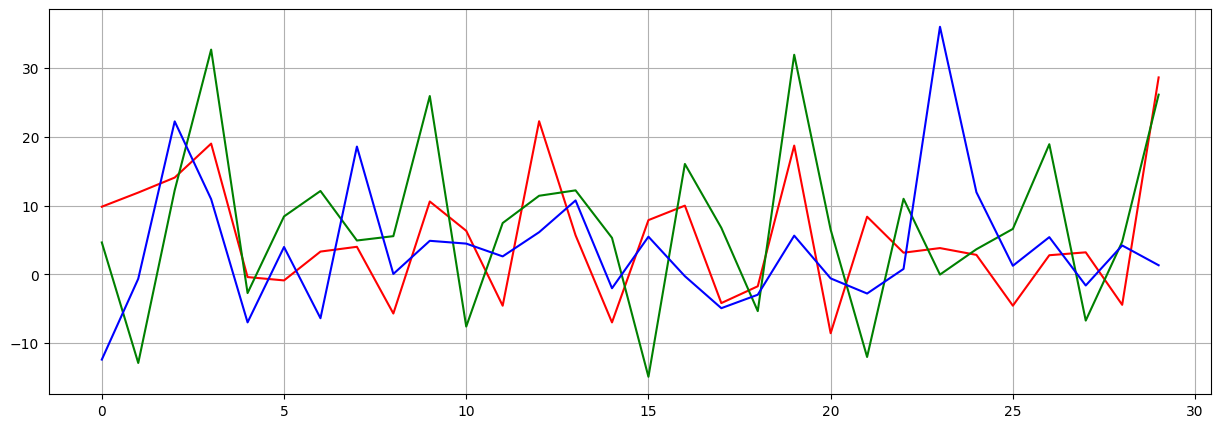

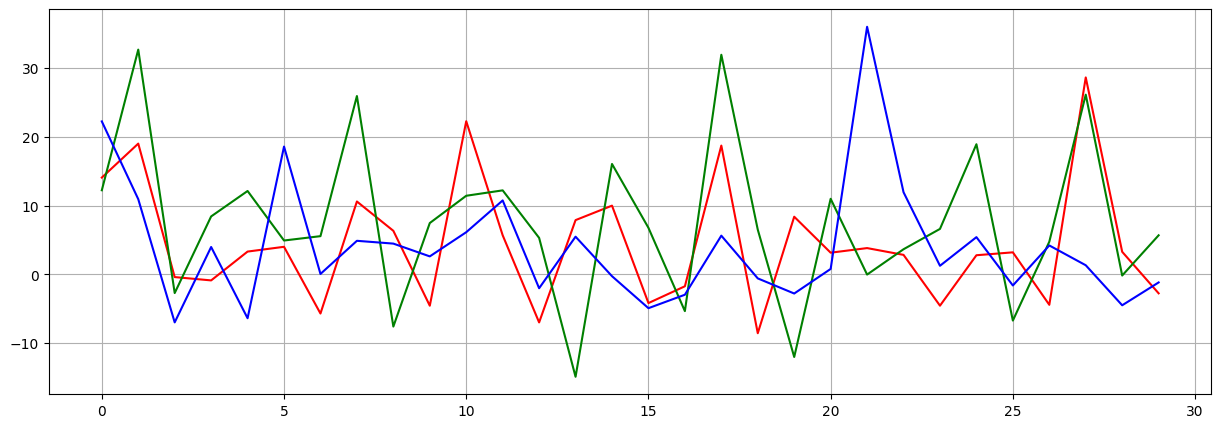

In [5]:
create_plots(running_list, columns_presentation, 5)

Наразі так само виведено 5 графіків

Візуально за графіками можна припустити, що для даної активності характерно:
1. Велика амплітуда значень по всім вісям (від -40 до 40)
2. Велике відхилення від середнього
3. Середнє здебільшого вище нуля
4. Можна помітити піки по окремим осям вверх

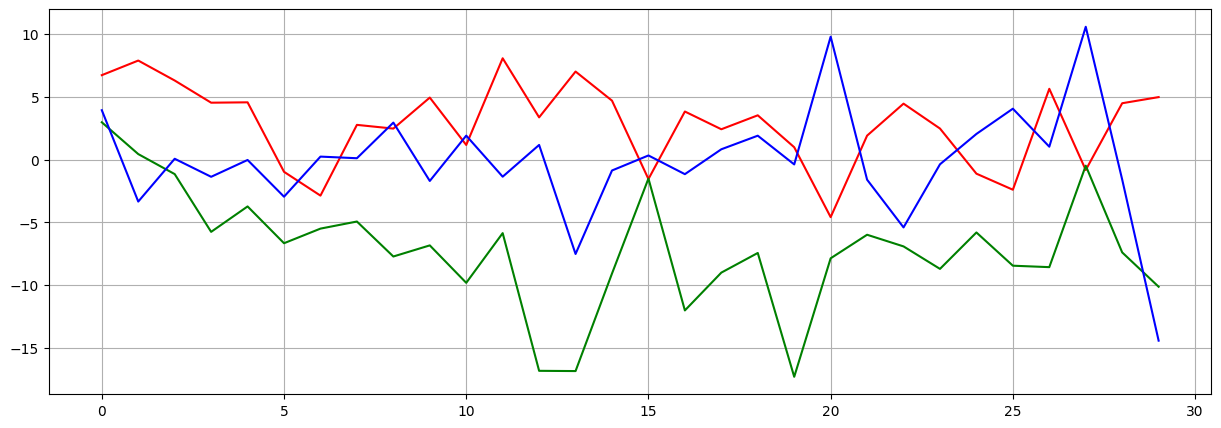

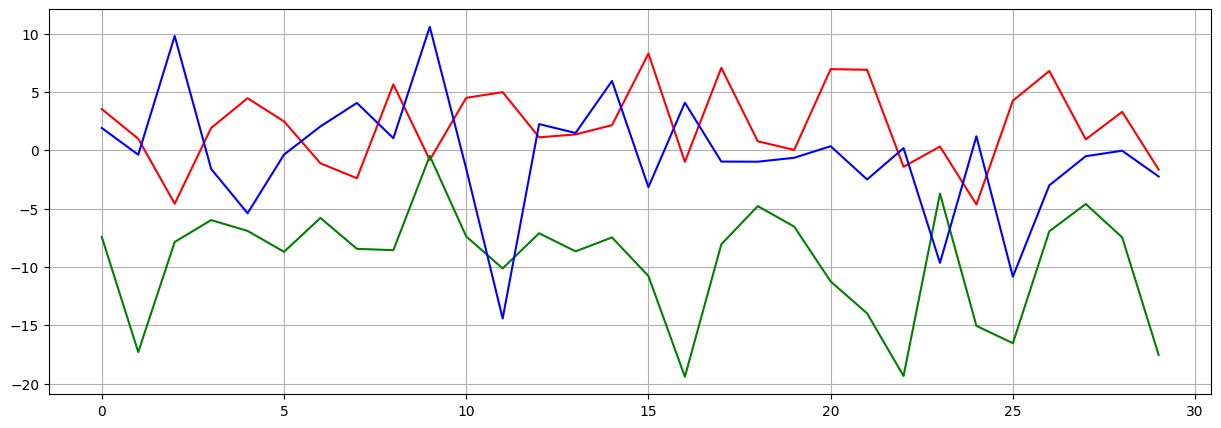

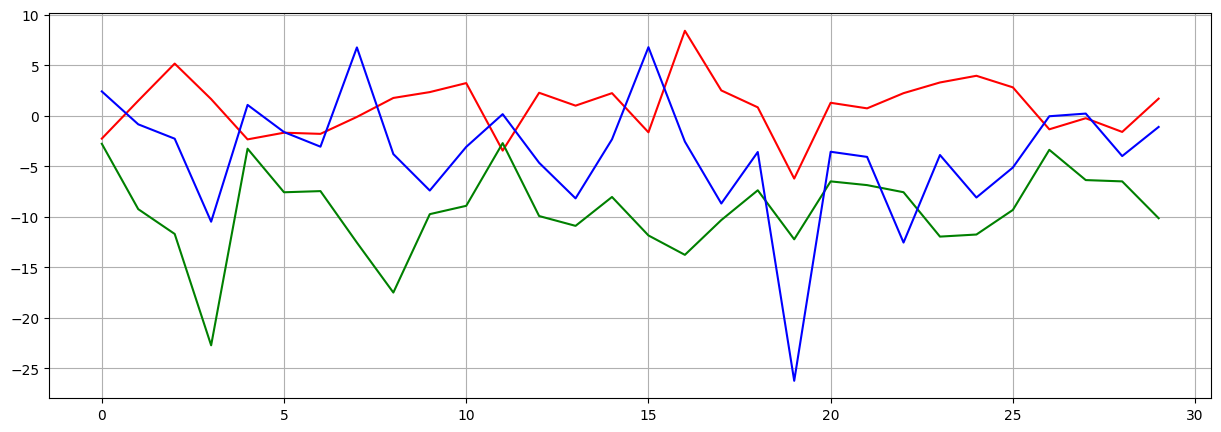

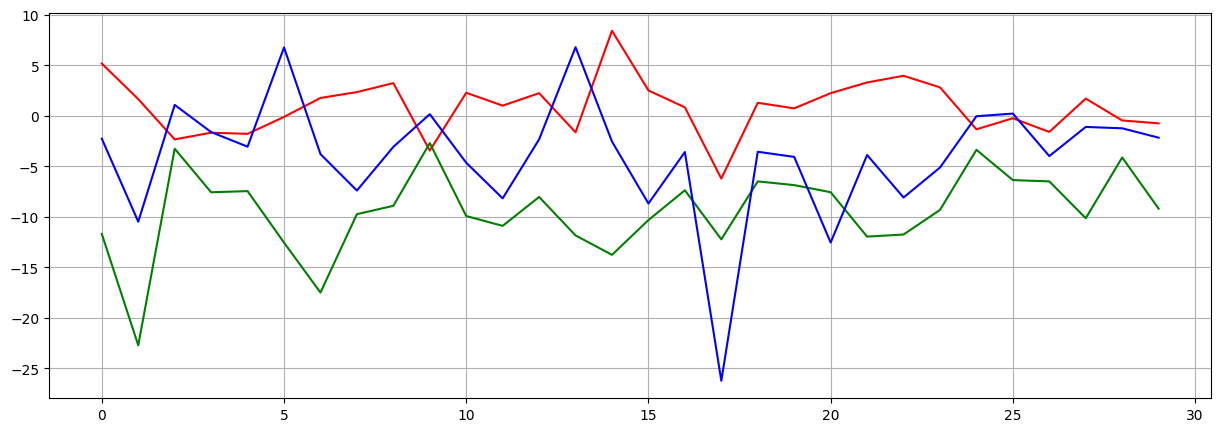

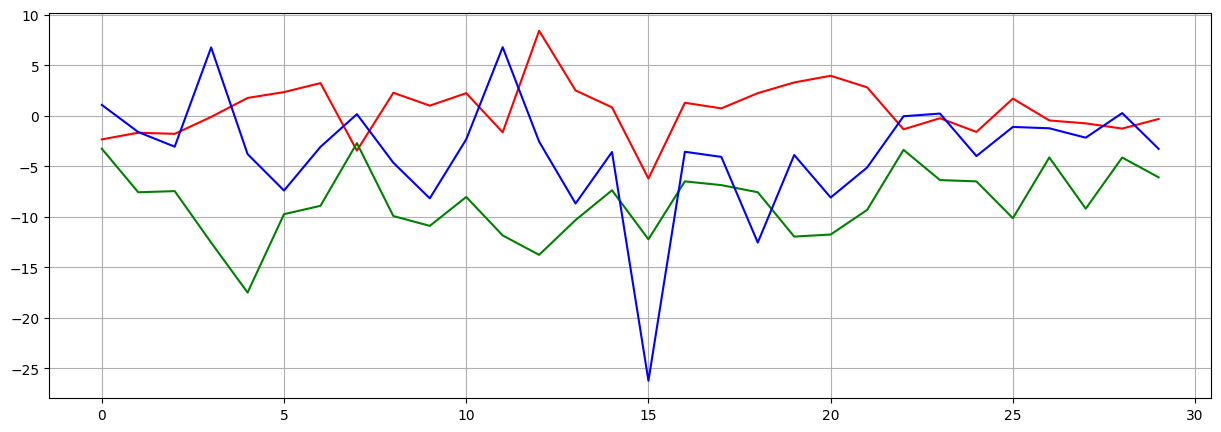

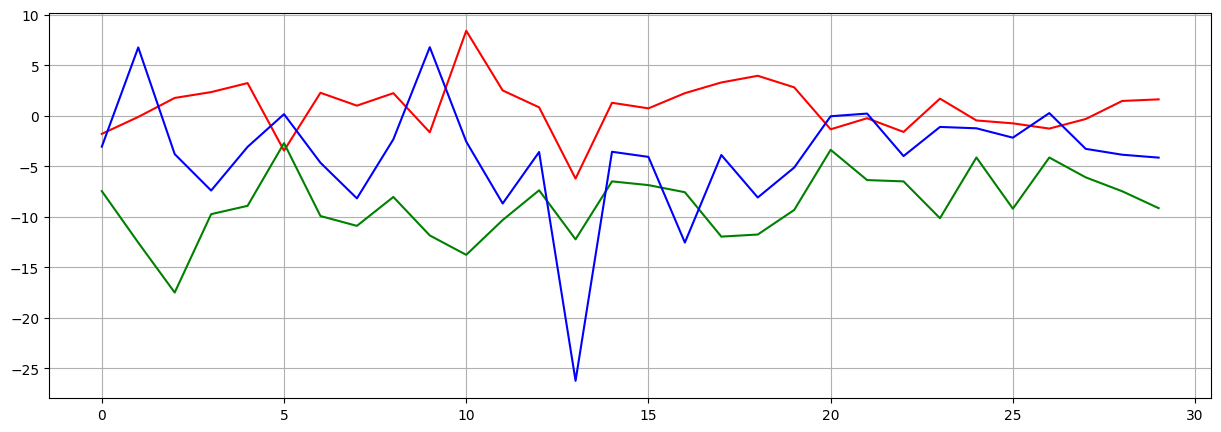

In [6]:
create_plots(stairs_list, columns_presentation, 5)

Так само 5 графіків дл сходів.

По всій виборці візуально відслідковуються наступні особливості:
1. Амплітуда значень від 10 до -40
2. Переважно по 2 з 3 осей середнє коливається дещо нижче нуля
3. Як мінімум по одній з осей є поодиникі піки вниз
4. Графіки більш пологі, ніж за даними бігу

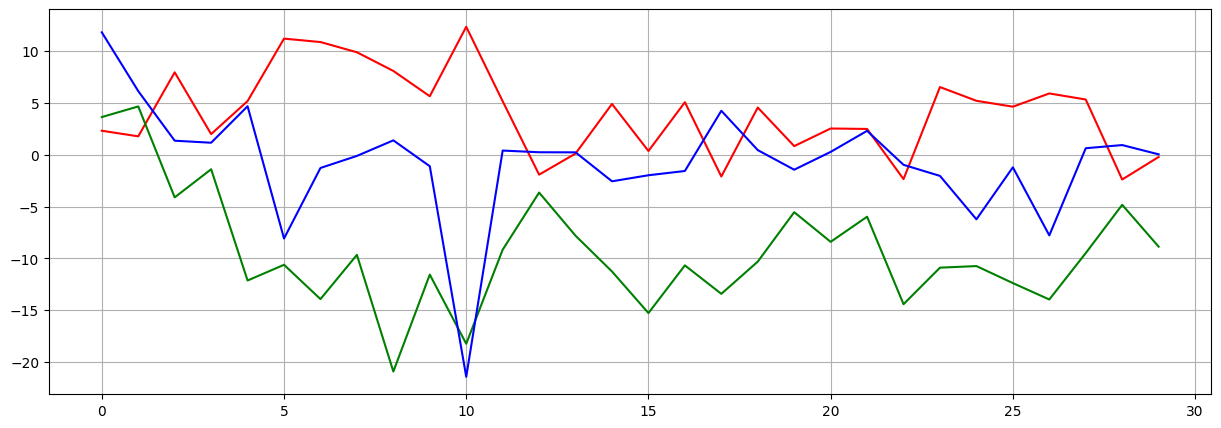

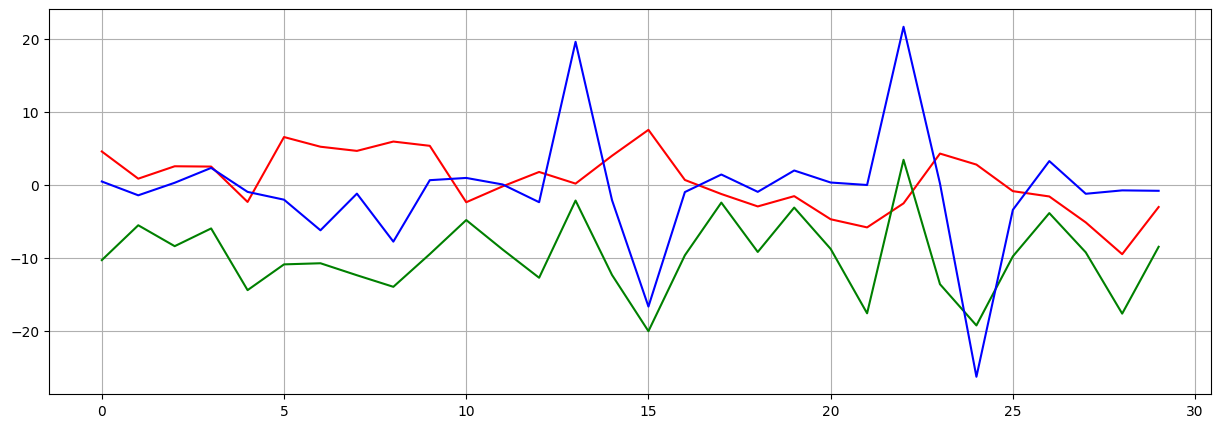

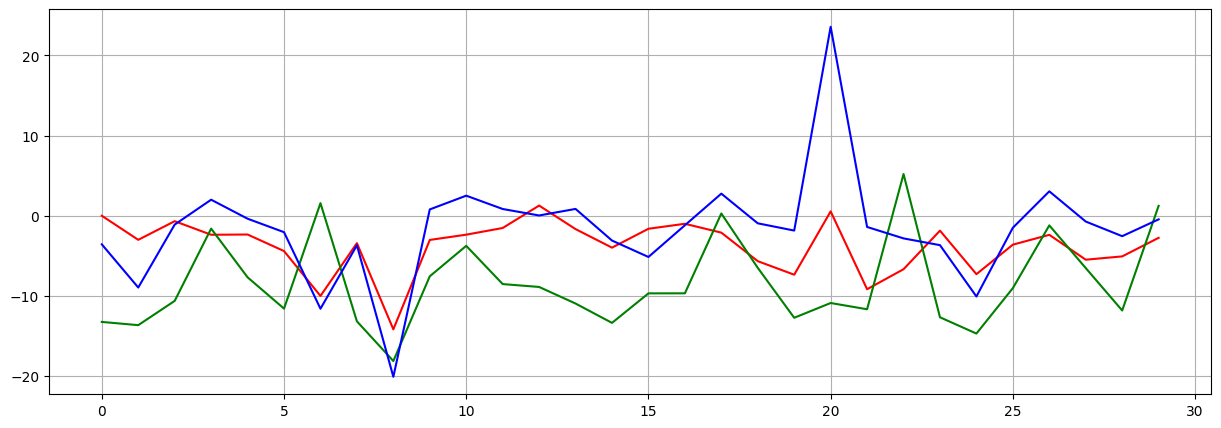

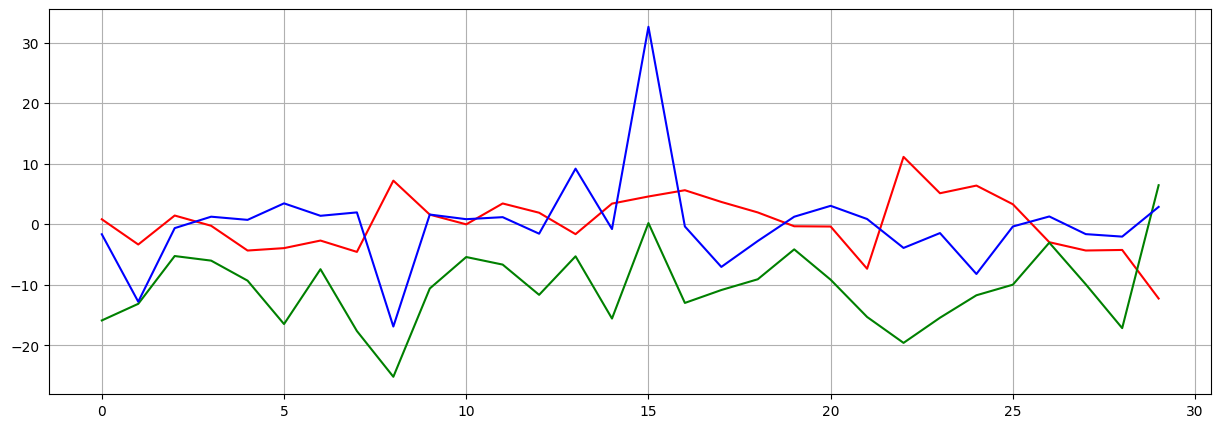

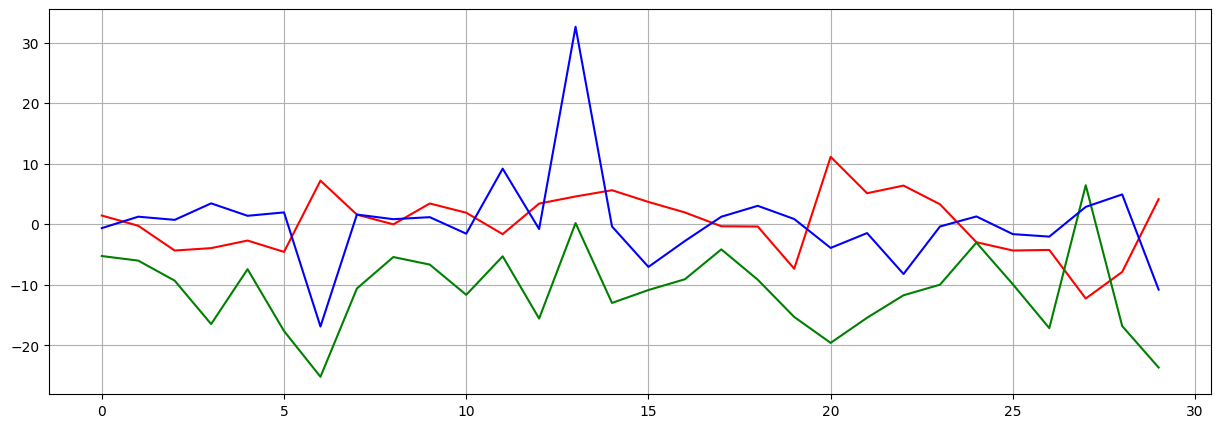

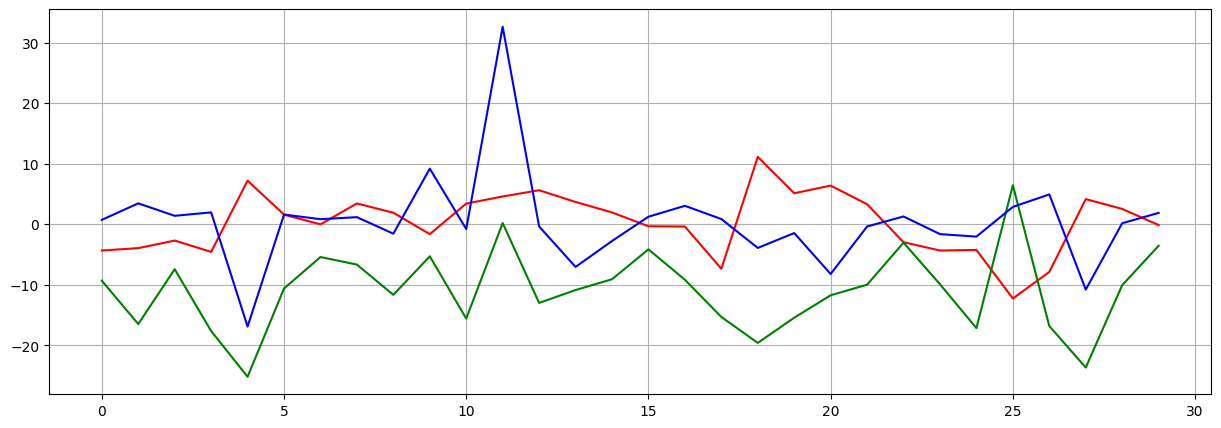

In [7]:
create_plots(walking_list, columns_presentation, 5)

І останні 5 графіків для ходьби:

1. Зазвичай невелика амплітуда коливань
2. Поодинокі піки вгору
3. Середня трохи нижче нуля

А тепер спробуємо вивести графік boxplot для перших 30 датафреймів по кожній з активностей.

In [8]:

def plot_boxes(data_list, caption:str, count = 20):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    fig.suptitle(caption)

    dataX = []
    dataY = []
    dataZ = []
    for i in range(count):
        dataX.append(data_list[i]["accelerometer_X"])
        dataY.append(data_list[i]["accelerometer_Y"])
        dataZ.append(data_list[i]["accelerometer_Z"])

    axs[0].boxplot(dataX)
    axs[1].boxplot(dataY)
    axs[2].boxplot(dataZ)
    
    plt.show()




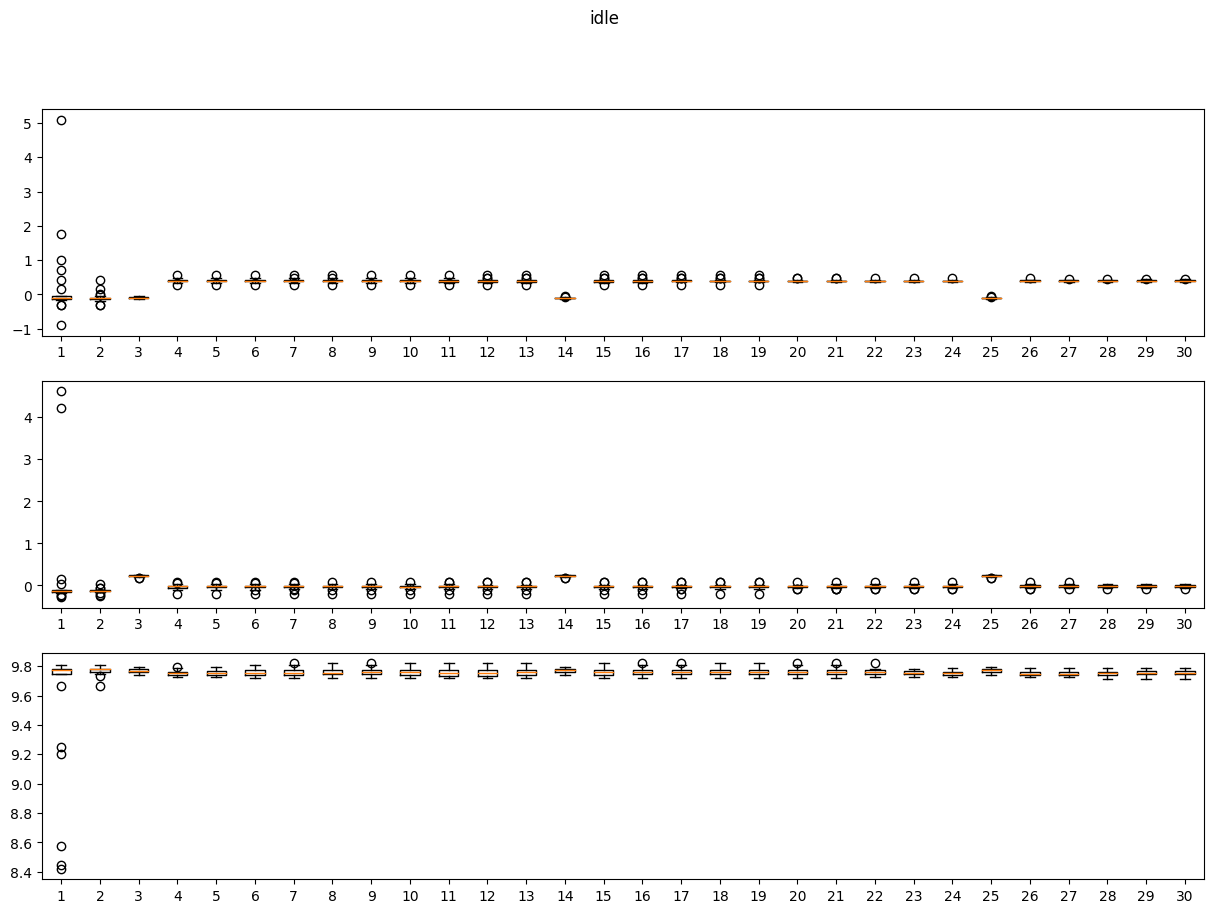

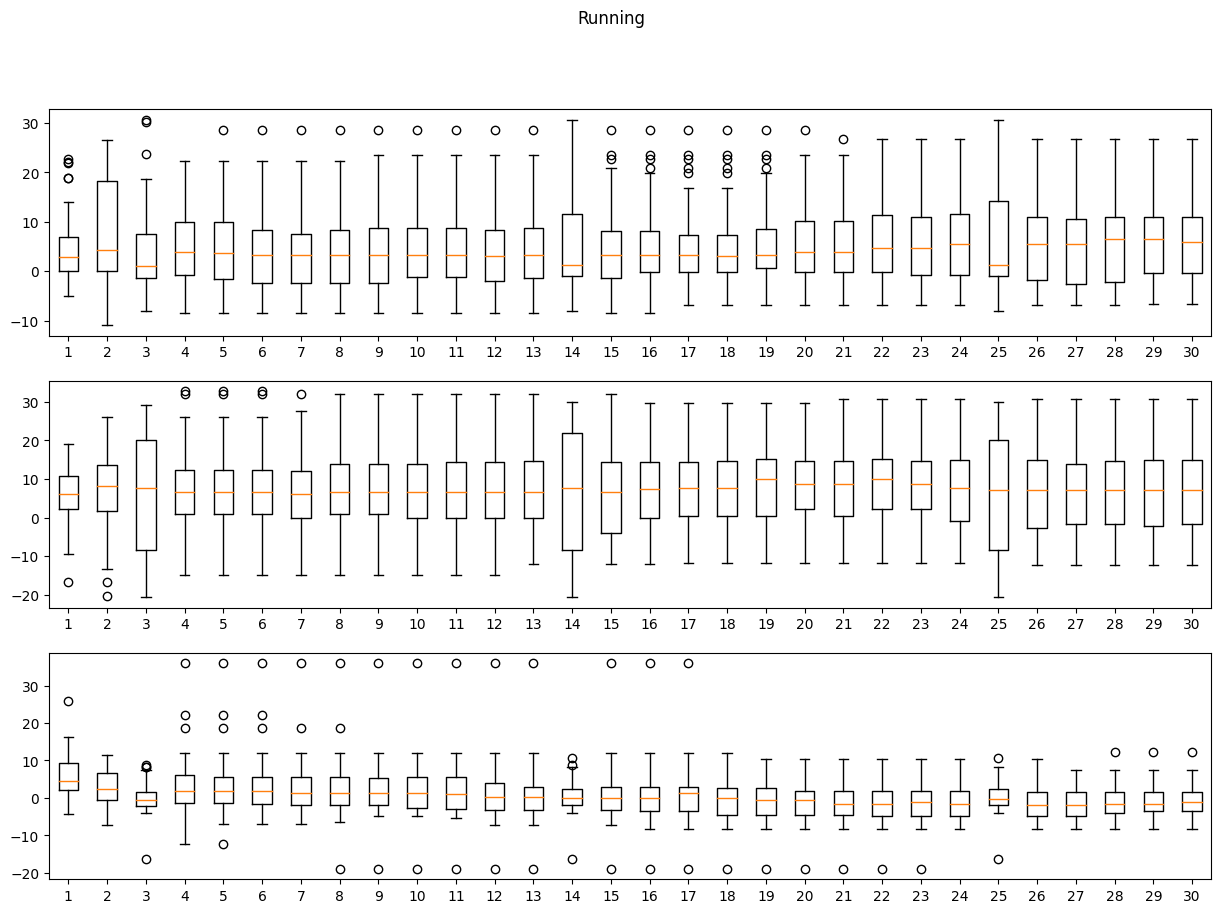

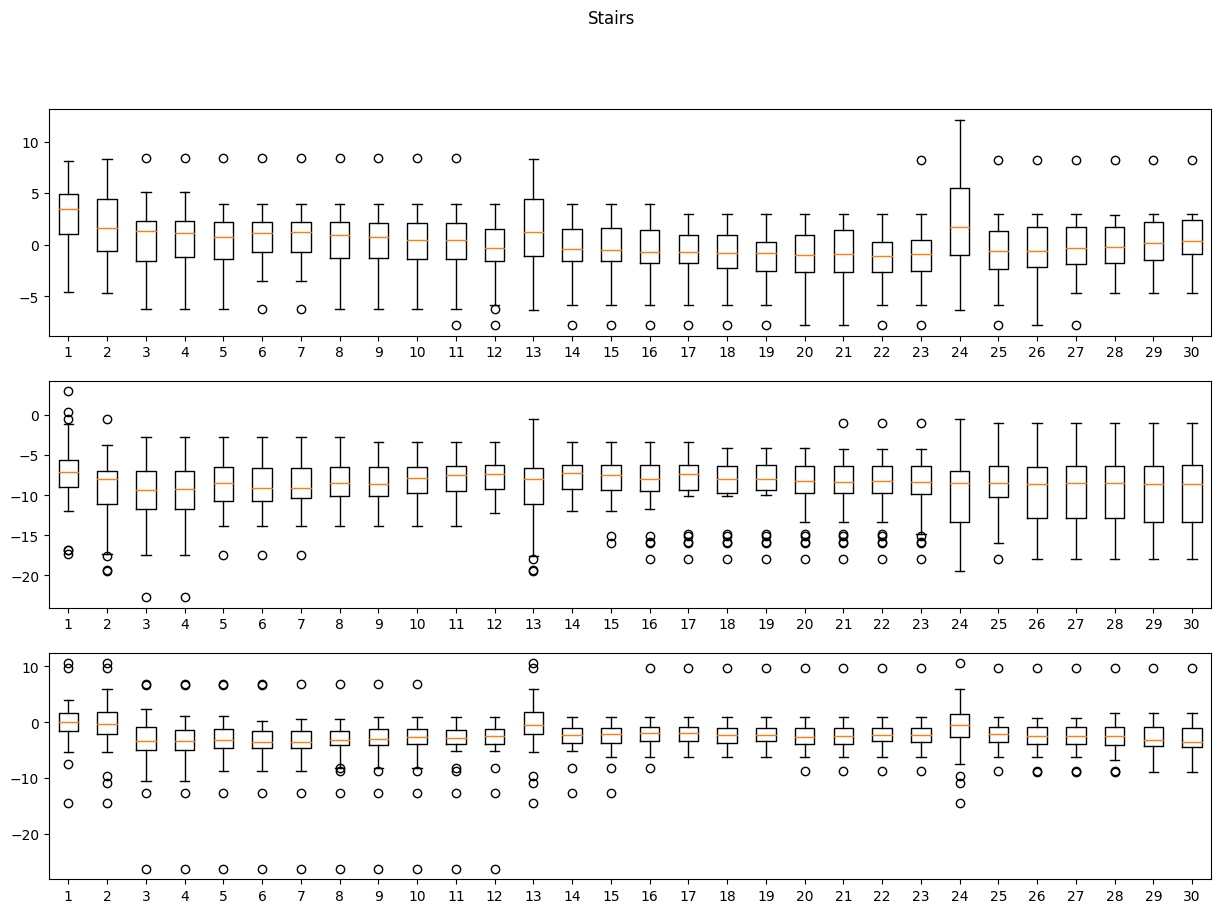

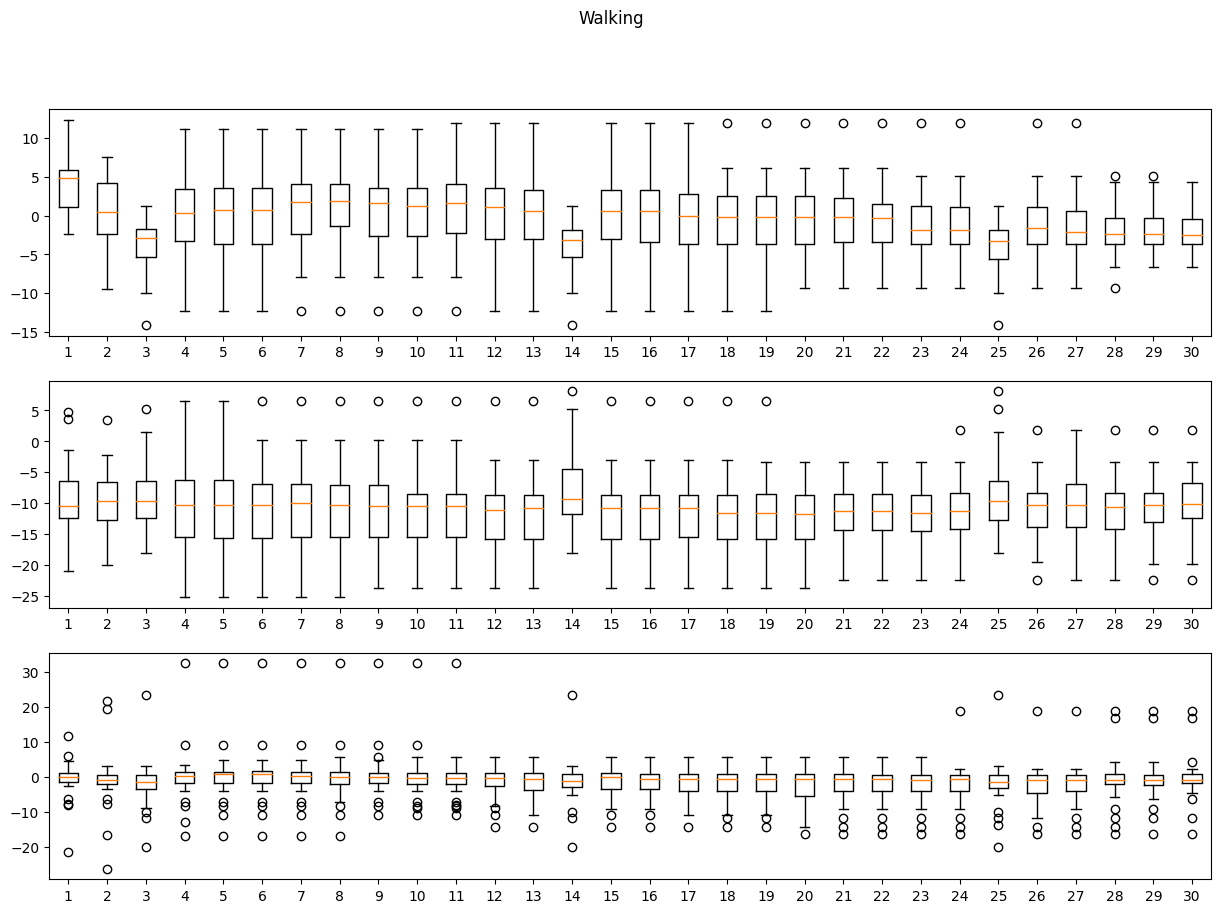

In [9]:
plot_boxes(iddle_list, "idle", 30)
plot_boxes(running_list, "Running", 30)
plot_boxes(stairs_list, "Stairs", 30)
plot_boxes(walking_list, "Walking", 30)

Використавши boxplot, який узагальнює статистичну інформацію по одиничним наборам даних, ми ще раз підтвердили зроблені раніше припущення.

Тепер обробимо наші датафрейми

In [10]:
def prepare_features(data_list):
    for i in range(len(data_list)):
        data_list[i]["id"] = i

    df = pd.concat(data_list).reset_index(drop=True)

    extraction_settings = {
        "abs_energy": None,
        "median": None,
        "mean": None,
        "standard_deviation": None,
        "variation_coefficient": None,
        "skewness": None,
        "kurtosis": None,
        #"sample_entropy": None,
        "maximum": None,
        "minimum": None#,
        #"range_count": [{'min': -1, 'max': 1}, {'min': 9, 'max': 11}, {'min': 5, 'max': 1000000000000.0}, {'min': -1000, 'max': 0}, {'min': -1000, 'max': -5}]
    }
    df_features = tsfresh.extract_features(df, column_id="id", default_fc_parameters=extraction_settings)
    
    return df_features

In [11]:
idle_features = prepare_features(iddle_list)
running_features = prepare_features(running_list)
stairs_features = prepare_features(stairs_list)
walking_features = prepare_features(walking_list)



Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


In [12]:
# print(running_features[running_features.isnull()])
# print(running_features)
# print(stairs_features)
# print(walking_features)

IDLE = 0
RUNNING = 1
STAIRS = 2
WALKING = 3

# idle_features["activity"] = IDLE
# running_features["activity"] = RUNNING
# stairs_features["activity"] = STAIRS
# walking_features["activity"] = WALKING

idle_y = pd.DataFrame([IDLE for i in range(len(idle_features))])
running_y = pd.DataFrame([RUNNING for i in range(len(running_features))])
stairs_y = pd.DataFrame([STAIRS for i in range(len(stairs_features))])
walking_y = pd.DataFrame([WALKING for i in range(len(walking_features))])


Перемішування, поділ, підготовка навчальних, валідаційних та тестових фреймів 

In [13]:
# model = DecisionTreeClassifier()
# model.fit()


# ліпимо всі вибірки докупи
x_full = pd.concat([idle_features, running_features, stairs_features, walking_features]).reset_index(drop=True)
y_full = pd.concat([idle_y, running_y, stairs_y, walking_y]).reset_index(drop=True)[0].tolist()


x_train, x_valid, y_train, y_valid = train_test_split(x_full, y_full, test_size=0.4, shuffle=True, stratify=y_full)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size=0.5, shuffle=True, stratify=y_valid)



Створюємо першу модель, перевіряємо чи добре у нас з програмуванням

In [14]:
# svc poly
svc_poly = SVC(kernel="poly", C=1, degree=4, probability=True)
svc_poly.fit(x_train, y_train)


SVC(C=1, degree=4, kernel='poly', probability=True)

In [15]:
y_valid_pred = svc_poly.predict(x_valid)
y_valid_pred_proba = svc_poly.predict_proba(x_valid)


In [16]:
accuracy_score(y_valid, y_valid_pred)

0.9319412219644239

In [17]:
f1_score(y_valid, y_valid_pred, average="micro")

0.9319412219644239

In [18]:
roc_auc_score(y_valid, y_valid_pred_proba, multi_class="ovr") 

0.9705455327104577

Проганяємо декілька моделей, розрраховуємо метрики для валідаційних і тестових даних

In [19]:
list_of_tests = []

def test_svc_model(model, x_v, y_v, x_t, y_t, model_verb = "", h_params = ""):
    y_valid_pred = model.predict(x_v)
    y_valid_pred_proba = model.predict_proba(x_v)
    print(" Validation")
    v_acc_score = accuracy_score(y_v, y_valid_pred)
    print(f"Accuracy {v_acc_score}")
    v_f1_score = f1_score(y_v, y_valid_pred, average='micro')
    print(f"f1 {v_f1_score}")
    v_roc = roc_auc_score(y_v, y_valid_pred_proba, multi_class='ovr')
    print(f"ROC {v_roc}")
    
    y_test_pred = model.predict(x_t)
    y_test_pred_proba = model.predict_proba(x_t)
    print(" Test")
    t_acc_score = accuracy_score(y_t, y_test_pred)
    print(f"Accuracy {t_acc_score}")
    t_f1_score = f1_score(y_t, y_test_pred, average='micro')
    print(f"f1 {t_f1_score}")
    t_roc = roc_auc_score(y_t, y_test_pred_proba, multi_class='ovr') 
    print(f"ROC {t_roc}")

    list_of_tests.append({"model": model_verb, "h_params": h_params, "v_acc_score": v_acc_score, "v_f1_score": v_f1_score, "v_roc": v_roc, "t_acc_score": t_acc_score, "t_f1_score": t_f1_score, "t_roc": t_roc})


In [20]:
print('kernel="poly", degree [2-7]')
for i in range(2, 8, 1):
    print(f"************** Degree {i} ****************")
    svc_poly = SVC(kernel="poly", C=1, degree=i, probability=True)
    svc_poly.fit(x_train, y_train)
    # y_valid_pred = svc_poly.predict(x_valid)
    # y_valid_pred_proba = svc_poly.predict_proba(x_valid)
    # print(" Validation")
    # print(f"Accuracy {accuracy_score(y_valid, y_valid_pred)}")
    # print(f"f1 {f1_score(y_valid, y_valid_pred, average='micro')}")
    # print(f"ROC {roc_auc_score(y_valid, y_valid_pred_proba, multi_class='ovr') }")
    
    # y_test_pred = svc_poly.predict(x_test)
    # y_test_pred_proba = svc_poly.predict_proba(x_test)
    # print(" Test")
    # print(f"Accuracy {accuracy_score(y_test, y_test_pred)}")
    # print(f"f1 {f1_score(y_test, y_test_pred, average='micro')}")
    # print(f"ROC {roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr') }")
    test_svc_model(svc_poly, x_valid, y_valid, x_test, y_test, model_verb="svc_poly", h_params=f"degree {i}")

print('kernel="rbf"')

svc_rbf = SVC(kernel="rbf", C=1, probability=True)
svc_rbf.fit(x_train, y_train)
test_svc_model(svc_rbf, x_valid, y_valid, x_test, y_test, model_verb="svc_rbf", h_params="")


kernel="poly", degree [2-7]
************** Degree 2 ****************
 Validation
Accuracy 0.9481825212683681
f1 0.9481825212683681
ROC 0.9819826139487415
 Test
Accuracy 0.9481424148606811
f1 0.9481424148606811
ROC 0.9814095769944284
************** Degree 3 ****************
 Validation
Accuracy 0.945862335653519
f1 0.945862335653519
ROC 0.980922551537486
 Test
Accuracy 0.9442724458204335
f1 0.9442724458204335
ROC 0.9797072235920906
************** Degree 4 ****************
 Validation
Accuracy 0.9319412219644239
f1 0.9319412219644239
ROC 0.9691933539285323
 Test
Accuracy 0.9365325077399381
f1 0.9365325077399381
ROC 0.9692961455820366
************** Degree 5 ****************
 Validation
Accuracy 0.8994586233565351
f1 0.8994586233565351
ROC 0.9661027237417804
 Test
Accuracy 0.901702786377709
f1 0.901702786377709
ROC 0.967002732228569
************** Degree 6 ****************
 Validation
Accuracy 0.8584686774941995
f1 0.8584686774941995
ROC 0.9645227832903648
 Test
Accuracy 0.868421052631579

Дерево рішень з коробки

In [21]:
# model_dt = DecisionTreeClassifier()
# model_dt.fit(x_train, y_train)
# test_svc_model(model_dt, x_valid, y_valid, x_test, y_test)

# model_rf = RandomForestClassifier()
# model_rf.fit(x_train, y_train)
# test_svc_model(model_rf, x_valid, y_valid, x_test, y_test)

crit_list = ["gini", "entropy", "log_loss"]
n_est_list = [i for i in range(10, 201, 20)]

for crit in crit_list:
    print(f"******** criterion {crit}")
    for n_est in n_est_list:
        print(f"--- n_estimators {n_est}")
        model_rf = RandomForestClassifier(criterion=crit, n_estimators=n_est)
        model_rf.fit(x_train, y_train)
        test_svc_model(model_rf, x_valid, y_valid, x_test, y_test, model_verb="RandomForestClassifier", h_params=f"crit {crit}, n_est {n_est}")

             

******** criterion gini
--- n_estimators 10
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9953560371517027
f1 0.9953560371517027
ROC 0.9999205415438042
--- n_estimators 30
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9992260061919505
f1 0.9992260061919505
ROC 0.9999864997628174
--- n_estimators 50
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9992260061919505
f1 0.9992260061919505
ROC 1.0
--- n_estimators 70
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9984520123839009
f1 0.9984520123839009
ROC 0.9999827582850427
--- n_estimators 90
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 1.0
f1 1.0
ROC 1.0
--- n_estimators 110
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9984520123839009
f1 0.9984520123839009
ROC 0.9999932498814087
--- n_estimators 130
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 1.0
f1 1.0
ROC 1.0
--- n_estimators 150
 Validation
Accuracy 1.0
f1 1.0
ROC 1.0
 Test
Accuracy 0.9992260061919505
f1 0.999226

In [22]:
df_res = pd.DataFrame.from_records(list_of_tests)
print(df_res)

                     model                  h_params  v_acc_score  v_f1_score  \
0                 svc_poly                  degree 2     0.948183    0.948183   
1                 svc_poly                  degree 3     0.945862    0.945862   
2                 svc_poly                  degree 4     0.931941    0.931941   
3                 svc_poly                  degree 5     0.899459    0.899459   
4                 svc_poly                  degree 6     0.858469    0.858469   
5                 svc_poly                  degree 7     0.907193    0.907193   
6                  svc_rbf                               0.950503    0.950503   
7   RandomForestClassifier       crit gini, n_est 10     1.000000    1.000000   
8   RandomForestClassifier       crit gini, n_est 30     1.000000    1.000000   
9   RandomForestClassifier       crit gini, n_est 50     1.000000    1.000000   
10  RandomForestClassifier       crit gini, n_est 70     1.000000    1.000000   
11  RandomForestClassifier  

1. На даному датасеті випадковий ліс показав себе краще, ніж SVM
2. Дизайн параметрів (включення додаткових, чи навпаки, виключення тих, що здавалися важливими на підготовчому етапі) досить суттєво впливає на якість роботи моделі
3. 1 в метриках якості трохи лякає (чи не відбулося перенавчання), але декілька прогонів з розділенням даних, а також узгодженність у метриках валідаційної та тестової виборок, дозволяє сказати, що модель спрацювала добре 
4. Найкраще себе показала модель "Випадковий ліс" з параметрами criterion: log_loss, n_estimators 130 та 150 (після декількох рестартів)